In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso, ElasticNetCV, ElasticNet, LarsCV, Lars, OrthogonalMatchingPursuitCV, OrthogonalMatchingPursuit
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import f_classif, f_regression
from sklearn.impute import KNNImputer, MissingIndicator
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from utils import *

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import periodogram

In [2]:
df = pd.read_csv("kaggle_data/test_data.csv", index_col = 'Id')

In [3]:
df 

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V991,V992,V993,V994,V995,V996,V997,V998,V999,V1000
Id,,,,,,,,,,,,,,,,,,,,,
1,94.111590,95.447586,96.726211,97.147048,95.613294,94.690922,94.402398,94.402826,96.813676,97.583465,...,75.776073,75.220229,74.968105,74.996296,75.955661,74.927599,75.935808,76.633174,75.871778,75.526783
2,93.550189,92.899123,93.828865,93.992301,93.863663,90.708771,89.491450,90.312653,89.964135,88.814115,...,107.392628,107.080932,108.455568,108.379854,109.553019,110.370786,110.159546,110.197563,109.423087,109.013025
3,78.232418,77.831144,76.367381,75.668888,74.772650,76.110550,76.986616,77.900798,78.214454,78.082119,...,121.967944,121.743296,122.756937,124.235713,123.320927,123.518787,123.016570,123.491181,123.600083,121.741557
4,90.255867,89.252764,89.493121,88.417598,88.189119,87.339292,87.986488,88.426919,89.215305,89.568456,...,77.651958,77.843225,76.443649,78.652677,78.733839,78.235345,77.080901,76.131494,76.926619,76.474487
5,92.370024,93.562420,92.227375,91.247307,91.441921,89.850272,90.941352,90.638395,90.179268,90.506362,...,102.955832,103.511776,102.660809,103.051544,103.788691,104.220779,104.676239,104.221633,103.852102,103.453873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,7.355146,8.355152,7.763687,7.753607,7.231822,6.273910,5.826566,5.397638,7.265989,7.718448,...,-20.916596,-19.199647,-18.570786,-18.898271,-19.415560,-20.558731,-20.556333,-20.380476,-18.987759,-18.721879
197,46.999057,47.972433,48.022745,47.942510,48.638841,48.245891,46.871270,46.704847,45.654930,47.703929,...,12.491214,11.791708,10.064555,10.447119,11.080012,11.080545,10.775786,10.511825,9.868243,10.155087
198,18.117520,17.935989,18.211744,18.709620,18.901795,17.835433,16.727459,16.190949,16.698970,18.216007,...,-16.089992,-15.846886,-17.365794,-16.085524,-15.498171,-15.000121,-13.583843,-13.462391,-12.758107,-14.398696


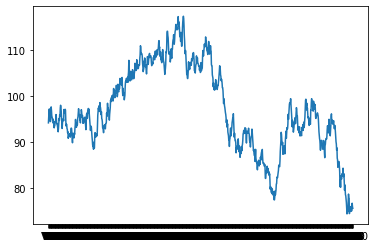

In [4]:
plt.plot(df.iloc[0]);

In [100]:
def create_sequences(data, seq_length, y_len = 1):
    xs = []
    ys = []

    for i in range(len(data)-(seq_length + y_len - 1)):
        x = data[i:(i+seq_length)]
        if y_len == 1:
            y = data[i+seq_length]
        else:
            y = data[i+seq_length:i+seq_length+y_len]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

def get_deviation(arr: np.array) -> np.array:
    return arr[1:] - arr[:-1]

class MyPredictor:
    def __init__(self, m = None):
        self.m = m
    
    def train(self, ts: np.array, params: list) -> tuple:
        ma = 10000000
        m_best = None
        
        X, y, last_column = self.get_train_data(ts)
        
        for m in params:
            assert m < X.shape[1]+1, f"m = {m} должно быть меньше L = {X.shape[1]}!"
            X_temp = X.T[-m:].T
            means = np.mean(X_temp, axis = 1)
            preds = means + last_column
            mse_error = ((y - preds)**2).mean()
            if mse_error < ma:
                m_best = m
                ma = mse_error
        self.m = m_best
        return (m_best, ma)

    def predict(self, X: np.array) -> np.array:
        assert self.m is not None, "Метод не обучен!"
        last_column = X.T[-1].T
        X = MyPredictor.to_deviation(X)
        X_temp = X.T[-self.m:].T
        means = np.mean(X_temp, axis = 1)
        return means + last_column
        
    def get_train_data(self, ts: np.array) -> tuple:
        X_temp, y = create_sequences(ts, L)
        X = MyPredictor.to_deviation(X_temp)
        return (X, y, X_temp.T[-1].T)
    
    @staticmethod
    def to_deviation(X: np.array) -> np.array:
        res = [get_deviation(X[i]) for i in range(X.shape[0])]
        return np.array(res)

In [121]:
# ===================================================
# ===================     BASE    ===================
# ===================================================
# def forecast_block(ts: pd.Series, L: int) -> np.array:
#     predictor = MyPredictor()
#     train = ts.to_numpy()
#     predictor.train(train, list(range(2, L)))
#     # print(L, predictor.m)
#     value = predictor.predict(np.array([train[-L:]]))[0]
#     res = np.zeros(100) + value
#     return res

### BEST RESULT
def forecast_block(ts: pd.Series, L: int) -> np.array:
    train = ts.to_numpy()
    nn = Ridge() 
    X, y = create_sequences(train, L, 1)
    nn.fit(X, y)
    # print(nn.alpha_)
    value = nn.predict(np.array([train[-L:]]))[0]
    res = np.zeros(100) + value
    return res

In [109]:
## ANSWER GENERATION CELL

L = 10
ans = []
new_index = []
outline = list(map(lambda x: '_' + str(x), list(range(1, 101)))) #
for inx, row in tqdm(df.iterrows()):
    res = forecast_block(row, L)
    ans.append(res)
    new_index += list(map(lambda x: str(inx) + x, outline)) #
answers_array = np.array(ans).reshape(-1)

0it [00:00, ?it/s]

In [110]:
answers = pd.DataFrame(answers_array, columns = ['Predicted'], index = pd.Index(new_index, name = 'Id'))
answers.to_csv('answers.csv')

# Реальные тесты

In [115]:
train, test = df.iloc[:, :900], df.iloc[:, 900:]
test = test.to_numpy()
test = test.reshape(-1)
test.shape

(20000,)

In [122]:
lL = np.arange(3, 500, 50)
ans = []
best_error = 1000000000000000
best_L = None
for L in tqdm(lL):
    ans = []
    for inx, row in train.iterrows():
        res = forecast_block(row, L)
        ans.append(res)
    answers_array = np.array(ans)
    #print(answers_array.shape)
    answers_array = answers_array.reshape(-1)
    error = mean_squared_error(answers_array, test, squared=False)
    if error < best_error:
        best_L = L
        best_error = error
best_L, best_error

  0%|          | 0/10 [00:00<?, ?it/s]

(3, 8.344650377594009)

In [96]:
L = 200
ans = []
for inx, row in tqdm(train.iterrows()):
    #print(inx)
    res = forecast_block(row, L)
    ans.append(res)
answers_array = np.array(ans)

0it [00:00, ?it/s]

In [97]:
answers_array = answers_array.reshape(-1)
answers_array.shape

(20000,)

In [98]:
answers_array

array([89.30513886, 89.30513886, 89.30513886, ..., 71.91022987,
       71.91022987, 71.91022987])

In [99]:
mean_squared_error(answers_array, test, squared=False)

8.444043484498469

In [78]:
answers_array[:100]

array([89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92264872,
       89.92264872, 89.92264872, 89.92264872, 89.92264872, 89.92